### Imports et initialisations

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import random

In [3]:
raw_dataset_file = "datasets/haine2022_oversampling_africain.txt"

### Chargement des données

In [22]:
with open(raw_dataset_file, "r") as file:
    raw_dataset = file.read().splitlines()

On prend un échantillon de messages

In [30]:
sample_size = 30

idx_list = random.Random(2).sample(range(len(raw_dataset)), sample_size)
raw_sample = [raw_dataset[i] for i in idx_list]

### Chargement du modèle et classification des données

#### Chargement depuis huggingface

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-french")
model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/dehatebert-mono-french")

#### Chargement depuis le disque

In [7]:
tokenizer = AutoTokenizer.from_pretrained("models/dehatebert_tokenizer")
model = AutoModelForSequenceClassification.from_pretrained("models/dehatebert_model")

Utilisation de la carte graphique si disponible

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
r = model.to(device)

### Classification de l'échantillon

In [31]:
%%time

predicted_classes_id = []
step = 10
max = 30
for i in range(0, max, step):
    inp = tokenizer(raw_sample[i:i+step], return_tensors='pt', padding=True, truncation=True)
    inp.to(device)
    with torch.no_grad():
        logits = model(**inp).logits
    predicted_classes_id += [elt.argmax().item() for elt in logits]

CPU times: user 292 ms, sys: 13.2 ms, total: 305 ms
Wall time: 293 ms


### Regroupement des messages par classe

In [32]:
n = 0
haineux = []
non_haineux = []
for i, msg in enumerate(raw_sample):#[:max]):
    if (predicted_classes_id[i] == 1):
        haineux.append(msg)
        n += 1
    else :
        non_haineux.append(msg)
print("{} messages haineux sur {}".format(n, len(raw_sample)))

17 messages haineux sur 30


#### Les messages classifiés comme haineux
- 2 messages litigieux
- 9 faux positifs
- 6 messages réellement haineux

In [33]:
for h in haineux: print(h)

Par contre critiquer et lâcher des « t’as un gros ventre » elles savent ces petasses
Marre de voir ce vieux babouin , pilier du Siècle , même quand il fait semblant de critiquer la gauche. Ras-le-bol de ces vieilles r*mbières qui commentent la vie politique française devant la même gourdasse décolorée.
si mané etait pas noir tu parlerais meme pas de lui sale acteur
En plus les gens en français peuvent dire sale noir et ils disent rien par rapport au mot noir💀
khel c’est renoi et ça veut pas dire sale macaque au cas où
Celui avec le jean bleu indigo, il a voulu faire le bogoss de l'équipe. Il abuse, même l'ak était noir ... Il dira au procès que son jean noir était en train de sécher ou qu'il était au sale ...
Liverpool a marqué juste après ta réponse sale chat noir
vendredi je serais brune, samedi j’suis blonde purée mais quel grâce d’être une negresse 😍😍😍😍
y'a zero argument je balances des phrases eco+ tu réponds comme un babouin
Un problème sale noir ?
La negresse mangeuse de banane,

#### Les messages classifiés comme non haineux
- un messages litigieux
- un message haineux
- le reste réellement non haineux

In [34]:
for n in non_haineux: print(n)

Macaque macaque macaque Macaque macaque macaque Macaque macaque macaque Macaque macaque macaque Macaque macaque macaque Macaque macaque macaque Macaque macaque macaque Macaque macaque macaque Macaque macaque macaque Macaque macaque macaque Macaque macaque
Renaud: «J'ai voté Macron… en me pinçant le nez».Ouah, quel rebelle!https://t.co/QOLaL8X1Mj
Zhahahah il t’aurait dit tu veux quoi salé noir, le très riche Samuel n’a pas notre temps
Solution alternative,l'homme noir est entré dans l'histoire bien avant qu'il est devenu l'homme blanc si je fais référence au théorique raciale que nos enfants nègre blanc ont inventé,pendant la période de l'esclavage.
Oh mais doux Jesus. Traitez nous de nègre, qu’on en finisse.
Non, la désinvolture est de changé de sujet quand on l'a soit même lancé : ici l'insulte d"arabe de service"/"négre de maison" lancé par TB....
Nous, les gros, les lunetteux, les rouquins, les boutonneux, les mal-fringués, les enfants de divorcés, les pas trop doués, on était trait

### Test sur le jeu de données étiqueté

On rappelle que ce jeu de données est biaisé envers le haineux

In [5]:
import pandas as pd 
data_hate = pd.read_pickle("data_hate.pkl")
tweets = list(data_hate['tweet'])
labels = list(data_hate['sentiment'])

In [6]:
from confmat import plot_confusion_matrix

In [8]:
%%time
#en cas de pb de mémoire
predicted_classes_id = []
step = 10
max = len(tweets)
for i in range(0, max, step):
    inp = tokenizer(tweets[i:i+step], return_tensors='pt', padding=True, truncation=True)
    inp.to(device)
    with torch.no_grad():
        logits = model(**inp).logits
    predicted_classes_id += [elt.argmax().item() for elt in logits]

CPU times: user 20.3 s, sys: 292 ms, total: 20.6 s
Wall time: 19.7 s


In [14]:
labs = ['haineux' if (elt == 1) else 'non haineux' for elt in labels]

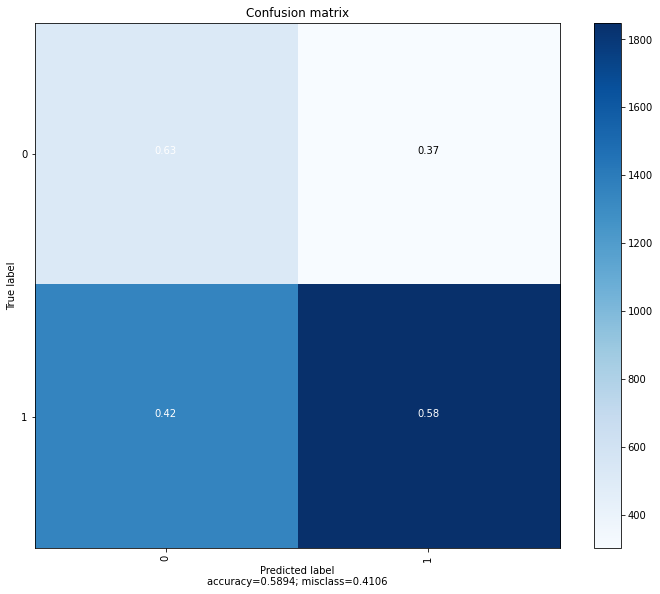

In [21]:
plot_confusion_matrix(labels, predicted_classes_id, [0, 1])